In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [20]:
import re

#setup
results = pd.read_pickle('../simulation_engine/results/binaryIV/N2000/results.pkl')

binaryIV = BinaryIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs


results

,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,ATE_2SLS-0.99_bound_lower,ATE_2SLS-0.99_bound_upper,ATE_2SLS-0.99_bound_valid,ATE_2SLS-0.99_bound_width,ATE_2SLS-0.99_bound_failed,ATE_2SLS-0.98_bound_lower,ATE_2SLS-0.98_bound_upper,ATE_2SLS-0.98_bound_valid,ATE_2SLS-0.98_bound_width,ATE_2SLS-0.98_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed,PNS_entropybounds-0.80_bound_lower,PNS_entropybounds-0.80_bound_upper,PNS_entropybounds-0.80_bound_valid,PNS_entropybounds-0.80_bound_width,PNS_entropybounds-0.80_bound_failed,PNS_entropybounds-0.20_bound_lower,PNS_entropybounds-0.20_bound_upper,PNS_entropybounds-0.20_bound_valid,PNS_entropybounds-0.20_bound_width,PNS_entropybounds-0.20_bound_failed,PNS_entropybounds-0.10_bound_lower,PNS_entropybounds-0.10_bound_upper,PNS_entropybounds-0.10_bound_valid,PNS_entropybounds-0.10_bound_width,PNS_entropybounds-0.10_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_manski_bound_lower,ATE_manski_bound_upper,ATE_manski_bound_width,ATE_manski_bound_failed,ATE_manski_bound_valid,PNS_manski_bound_lower,PNS_manski_bound_upper,PNS_manski_bound_width,PNS_manski_bound_failed,PNS_manski_bound_valid
0,889125,0,0,-0.881718,-0.152215,-5.000,-0.206909,-0.488076,0.003311,0.006563,0.494639,0.111197,0.880461,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, ...","[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.540750,0.481549,0.886126,0.886126,-1.000000,-0.237477,True,0.762523,False,-1.000000,-0.283819,True,0.716181,False,-0.589041,0.043600,True,0.632641,False,0.000000,0.322581,True,0.322581,False,-0.589041,0.127412,True,0.716453,False,-0.000000,3.225806e-01,True,3.225806e-01,False,-0.648000,0.344544,True,0.992544,False,-0.642198,-0.012275,True,0.629923,False,-0.609576,-0.177691,True,0.431885,False,8.905760e-08,0.699994,True,0.699994,False,1.663553e-07,0.436158,True,0.436158,False,0.000000e+00,0.238183,True,0.238183,False,-0.4551,-0.0933,False,0.3618,False,0.0000,0.3628,True,0.3628,False,-0.973684,0.137931,1.111615,False,True,0.000000,0.013158,0.013158,False,True
1,731872,0,0,-1.505266,0.905485,-4.995,1.507584,-0.544144,0.003710,0.010673,0.554817,0.140917,0.126780,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.540750,0.662260,0.999434,0.855451,-0.941015,-0.066721,True,0.874295,False,-0.898675,-0.109060,True,0.789615,False,-0.612903,-0.139932,True,0.472971,False,

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
    ATE_zaffalonbounds          0.00             4.25          0.4895
ATE_entropybounds_0.10          0.00             4.70          0.5897
       ATE_causaloptim          1.00             1.67          0.7137
ATE_entropybounds_0.20          0.00             1.65          0.7737
         ATE_autobound          1.20             0.96          0.7783
            ATE_manski          0.00             3.75          0.7804
ATE_entropybounds_0.80          0.00             1.35          0.9950
         ATE_2SLS_0.98          0.30             1.60          1.1199
         ATE_2SLS_0.99          0.30             1.20          1.1899


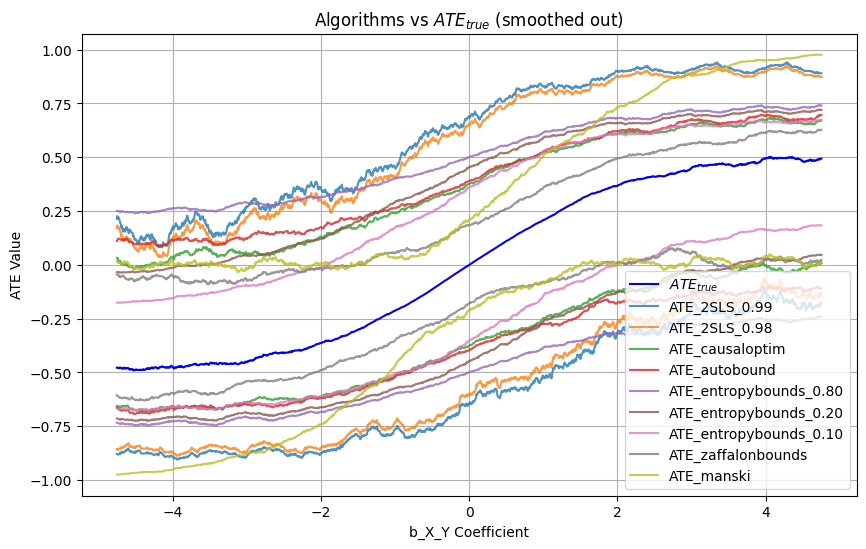

In [6]:
#ATE Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', ATE_algs, 100)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
            PNS_manski          0.00            22.20          0.1626
    PNS_zaffalonbounds          0.00             0.40          0.3972
       PNS_causaloptim          2.50             9.54          0.4030
         PNS_autobound          1.20             1.21          0.4243
PNS_entropybounds_0.10          0.00             0.00          0.5021
PNS_entropybounds_0.20          0.00             0.00          0.5781
PNS_entropybounds_0.80          0.00             0.00          0.7146


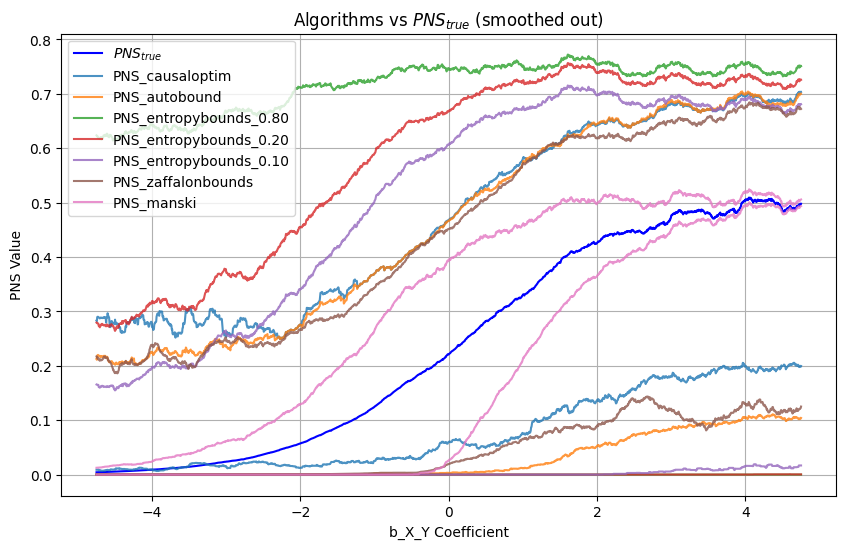

In [7]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

In [16]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bounds(df)
tb

,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,ATE_2SLS_0.99_bound_lower,ATE_2SLS_0.99_bound_upper,ATE_2SLS_0.99_bound_valid,ATE_2SLS_0.99_bound_width,ATE_2SLS_0.99_bound_failed,ATE_2SLS_0.98_bound_lower,ATE_2SLS_0.98_bound_upper,ATE_2SLS_0.98_bound_valid,ATE_2SLS_0.98_bound_width,ATE_2SLS_0.98_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds_0.80_bound_lower,ATE_entropybounds_0.80_bound_upper,ATE_entropybounds_0.80_bound_valid,ATE_entropybounds_0.80_bound_width,ATE_entropybounds_0.80_bound_failed,ATE_entropybounds_0.20_bound_lower,ATE_entropybounds_0.20_bound_upper,ATE_entropybounds_0.20_bound_valid,ATE_entropybounds_0.20_bound_width,ATE_entropybounds_0.20_bound_failed,ATE_entropybounds_0.10_bound_lower,ATE_entropybounds_0.10_bound_upper,ATE_entropybounds_0.10_bound_valid,ATE_entropybounds_0.10_bound_width,ATE_entropybounds_0.10_bound_failed,PNS_entropybounds_0.80_bound_lower,PNS_entropybounds_0.80_bound_upper,PNS_entropybounds_0.80_bound_valid,PNS_entropybounds_0.80_bound_width,PNS_entropybounds_0.80_bound_failed,PNS_entropybounds_0.20_bound_lower,PNS_entropybounds_0.20_bound_upper,PNS_entropybounds_0.20_bound_valid,PNS_entropybounds_0.20_bound_width,PNS_entropybounds_0.20_bound_failed,PNS_entropybounds_0.10_bound_lower,PNS_entropybounds_0.10_bound_upper,PNS_entropybounds_0.10_bound_valid,PNS_entropybounds_0.10_bound_width,PNS_entropybounds_0.10_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_manski_bound_lower,ATE_manski_bound_upper,ATE_manski_bound_width,ATE_manski_bound_failed,ATE_manski_bound_valid,PNS_manski_bound_lower,PNS_manski_bound_upper,PNS_manski_bound_width,PNS_manski_bound_failed,PNS_manski_bound_valid,ATE_tightest_bound,PNS_tightest_bound
0,889125,0,0,-0.881718,-0.152215,-5.000,-0.206909,-0.488076,0.003311,0.006563,0.494639,0.111197,0.880461,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, ...","[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.540750,0.481549,0.886126,0.886126,-1.000000,-0.237477,True,0.762523,False,-1.000000,-0.283819,True,0.716181,False,-0.589041,0.043600,True,0.632641,False,0.000000,0.322581,True,0.322581,False,-0.589041,0.127412,True,0.716453,False,-0.000000,3.225806e-01,True,3.225806e-01,False,-0.648000,0.344544,True,0.992544,False,-0.642198,-0.012275,True,0.629923,False,-0.609576,-0.177691,True,0.431885,False,8.905760e-08,0.699994,True,0.699994,False,1.663553e-07,0.436158,True,0.436158,False,0.000000e+00,0.238183,True,0.238183,False,-0.4551,-0.0933,False,0.3618,False,0.0000,0.3628,True,0.3628,False,-0.973684,0.137931,1.111615,False,True,0.000000,0.013158,0.013158,False,True,zaffalonbounds,manski
1,731872,0,0,-1.505266,0.905485,-4.995,1.507584,-0.544144,0.003710,0.010673,0.554817,0.140917,0.126780,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.540750,0.662260,0.999434,0.855451,-0.941015,-0.066721,True,0.874295,False,-0.898675,-0.109060,